In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [3]:
data = pd.read_csv('t-shirts.csv')
data.head()

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium


In [4]:
len(data)

20000

In [5]:
sizes = ['XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL']
materials = ['nylon', 'polyester', 'silk', 'cotton', 'linen']
colors = ['white', 'cream', 'blue', 'black', 'orange', 'green', 'yellow', 'red', 'violet', 'navy']
sleeves = ['long', 'short']
demands = ['low', 'medium', 'high']
attributes = ['size', 'material', 'color', 'sleeves']
attr_map = {'size': sizes, 'material': materials, 'color': colors, 'sleeves': sleeves}
goal = 'demand'

# Eksploracja danych
Jak zostało wymienione w liście 4, nasz zbiór danych skupia się na problemie zapotrzebowania na koszulki o danych parametrach, tj. cechami są rozmiar, materiał, kolor i rękawy, natomiast etykietą jest zapotrzebowanie.

In [6]:
data.isnull().sum()

size        0
material    0
color       0
sleeves     0
demand      0
dtype: int64

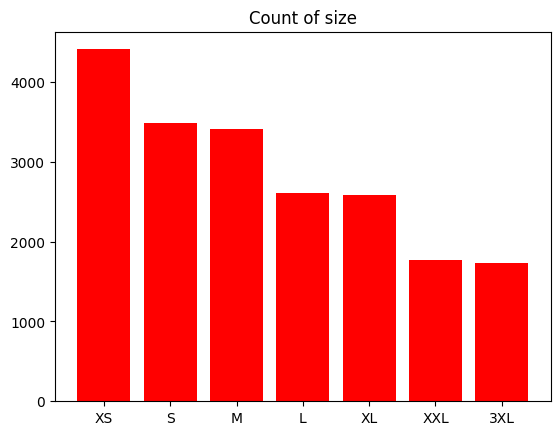

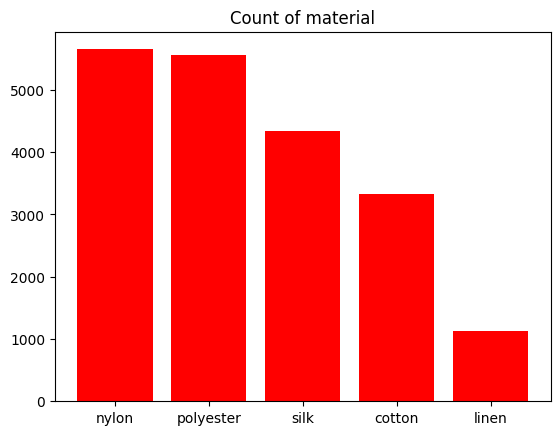

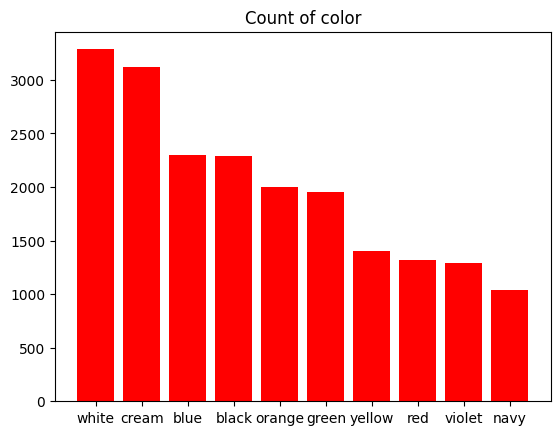

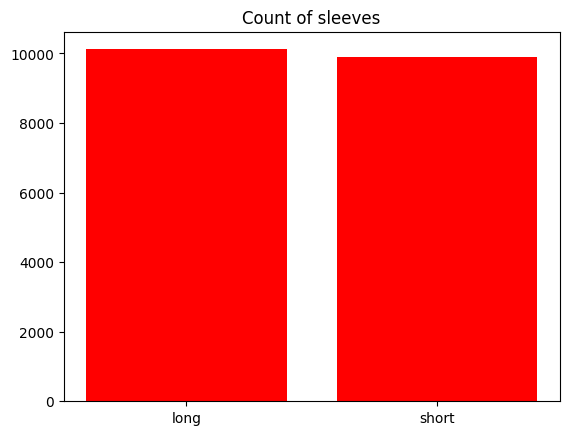

In [7]:
for attribute in attributes:
    attr_values = attr_map[attribute]
    count = data[attribute].value_counts()
    plt.bar(attr_values, count, color='red')
    plt.title(f'Count of {attribute}')
    plt.show()

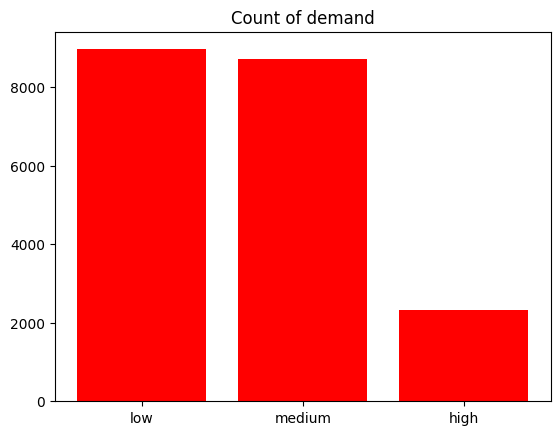

In [8]:
count = data[goal].value_counts()
plt.bar(demands, count, color='red')
plt.title('Count of demand')
plt.show()

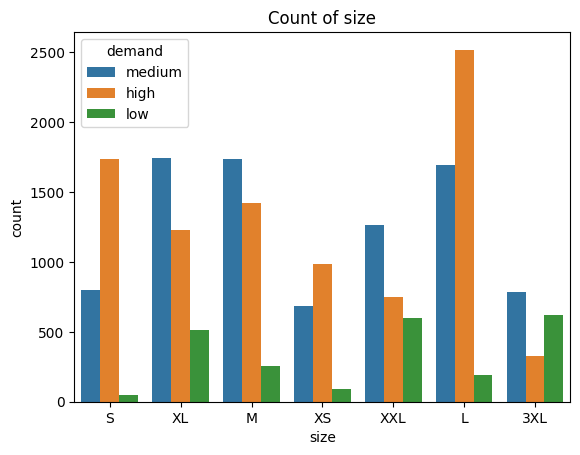

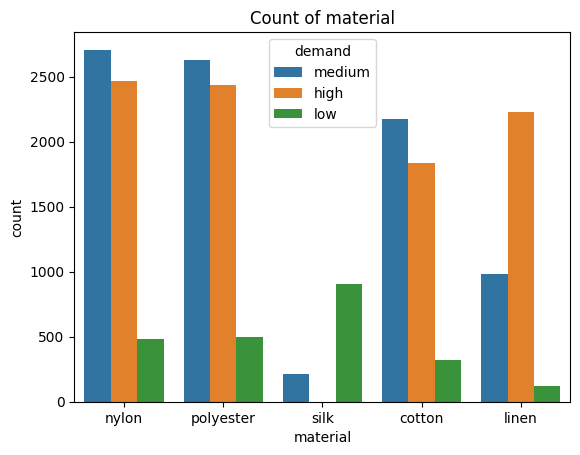

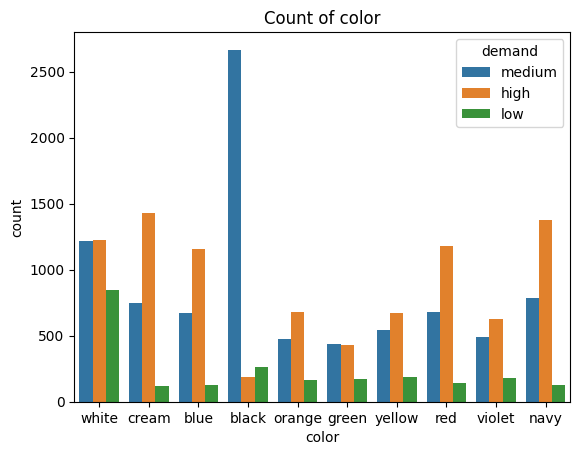

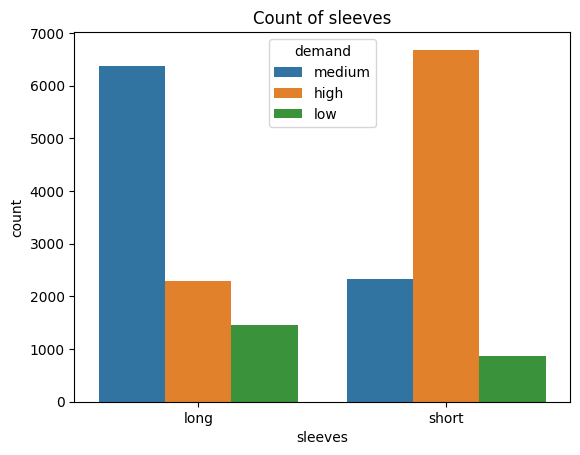

In [9]:
for attribute in attributes:
    sb.countplot(data, x=attribute, hue=data[goal])
    plt.title(f'Count of {attribute}')
    plt.show()

Powyżej zostały przedstawione podstawowe zestawienia dla zbioru danych. Można zauważyć, że dla każdej cechy mamy 0% wartość null oraz dla etykiet 0% wartości null. Patrząc się dalej można zauważyć, że najpopularniejsze są mniejsze rozmiary ubrań, nylonowe lub poliestrowe, białe lub kremowe. Długości rękawów są równomiernie rozłożone w zbiorze. Dodatkowo większość zestawień (kombinacji cech) t-shirtów ma zapotrzebowanie małe lub średnie. Na sam koniec można zobaczyć we własnym zakresie, jak wygląda zapotrzebowanie dla poszczególnych cech.

# Przygotowanie danych
Ponieważ zbiór danych zawiera większą ilość danych, liczoną w tysiącach można pozwolić na większy zestaw walidacyjny. Przyjmę proporcję 80/20, czyli 80% na zestaw uczący i 20% na zestaw walidacyjny.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

X = data.drop(goal, axis=1)
X_temp = encoder.fit_transform(X)
X = pd.DataFrame(X_temp.toarray(), columns=encoder.get_feature_names_out(X.columns))
Y = data[goal]

del(X_temp)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

Za wczasu można przygotować zbioru po różnych przetworzeniach, żeby sprawdzić ich wpływ na wyniki klasyfikacji. Wybrałem: standaryzację oraz PCA.

In [11]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA

standardizer = StandardScaler()
pca = PCA()

X_train_standardized = standardizer.fit_transform(X_train)
X_test_standardized = standardizer.transform(X_test)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Klasyfikacja
Następnie dokonam klasyfikacji uzyskanych zbiorów danych przy użyciu naiwnego Bayesa oraz drzewa decyzyjnego, dla każdego stosując 3 różne zestawy hiperparametrów.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

dtc1 = DecisionTreeClassifier()
dtc1_standardized = DecisionTreeClassifier()
dtc1_pca = DecisionTreeClassifier()

nb1 = GaussianNB()
nb1_standardized = GaussianNB()
nb1_pca = GaussianNB()

dtc1.fit(X_train, Y_train)
dtc1_standardized.fit(X_train_standardized, Y_train)
dtc1_pca.fit(X_train_pca, Y_train)

nb1.fit(X_train, Y_train)
nb1_standardized.fit(X_train_standardized, Y_train)
nb1_pca.fit(X_train_pca, Y_train)

hyperparameters_dtc = {
    "max_depth": [None, 5, 10, 15],
    "criterion": ['gini', 'entropy'],
    "max_leaf_nodes": [None, 5, 10, 15]
}

hyperparameters_nb = {
    "var_smoothing": [2e-9, 3e-9, 1e-8]
}

scoring_values = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro')
}

dtc2 = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=hyperparameters_dtc,
    cv=3,
    n_jobs=-1,
    scoring=scoring_values,
    refit='accuracy'
)

nb2 = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=hyperparameters_nb,
    cv=3,
    n_jobs=-1,
    scoring=scoring_values,
    refit='accuracy'
)

dtc2.fit(X_train, Y_train)
nb2.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [2e-09, 3e-09, 1e-08]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall': make_scorer(recall_score, response_method='predict', average=macro)})

# Ocena klasyfikacji
Na sam koniec można porównać wyniki (metryki) uzyskane przy pomocy różnych klasyfikatorów i je zinterpretować.

              precision    recall  f1-score   support

        high       0.98      0.99      0.98      1790
         low       0.95      0.95      0.95       465
      medium       0.97      0.97      0.97      1745

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

Accuracy: 0.9735


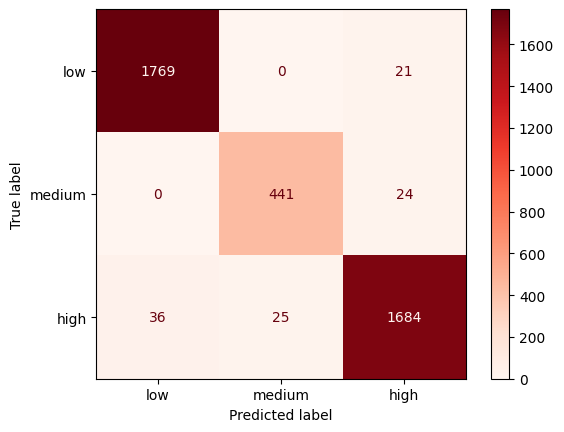

              precision    recall  f1-score   support

        high       0.98      0.99      0.98      1790
         low       0.95      0.95      0.95       465
      medium       0.97      0.97      0.97      1745

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

Accuracy: 0.9735


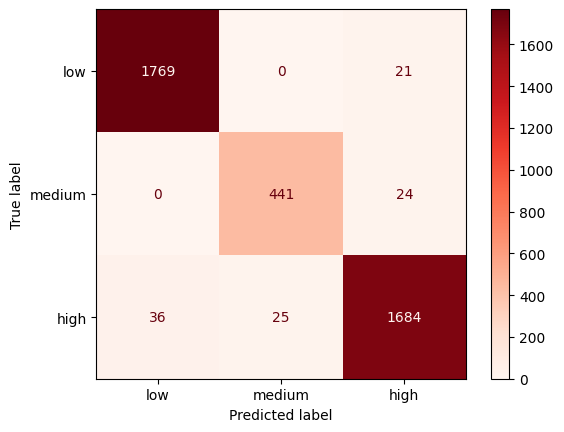

              precision    recall  f1-score   support

        high       0.98      0.99      0.98      1790
         low       0.95      0.95      0.95       465
      medium       0.97      0.97      0.97      1745

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

Accuracy: 0.9735


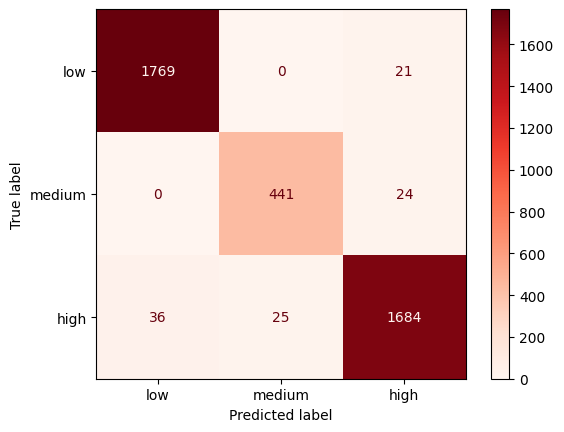

              precision    recall  f1-score   support

        high       0.56      0.98      0.72      1790
         low       0.73      0.48      0.58       465
      medium       0.90      0.30      0.46      1745

    accuracy                           0.63      4000
   macro avg       0.73      0.59      0.58      4000
weighted avg       0.73      0.63      0.59      4000

Accuracy: 0.62625


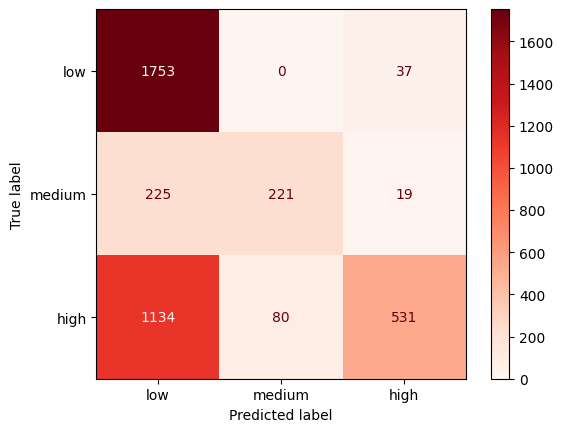

              precision    recall  f1-score   support

        high       0.56      0.98      0.71      1790
         low       0.77      0.48      0.59       465
      medium       0.90      0.30      0.46      1745

    accuracy                           0.63      4000
   macro avg       0.74      0.59      0.59      4000
weighted avg       0.73      0.63      0.59      4000

Accuracy: 0.62625


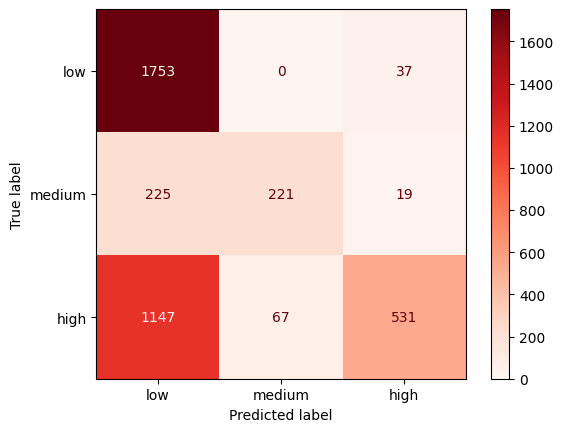

              precision    recall  f1-score   support

        high       0.70      0.80      0.75      1790
         low       0.59      0.55      0.57       465
      medium       0.67      0.57      0.62      1745

    accuracy                           0.67      4000
   macro avg       0.65      0.64      0.64      4000
weighted avg       0.67      0.67      0.67      4000

Accuracy: 0.6745


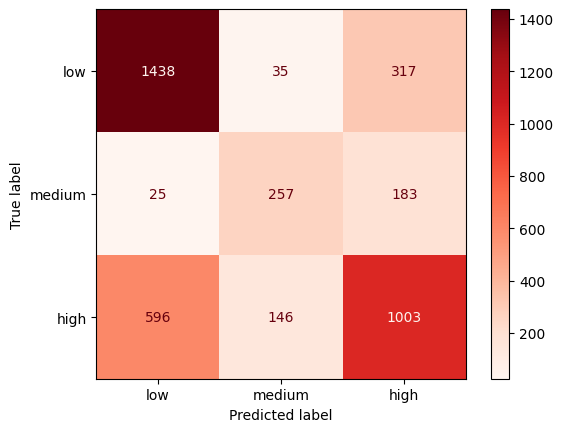

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def visualize(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=demands).plot(cmap=plt.cm.Reds)
    plt.show()

Y_pred = dtc1.predict(X_test)
visualize(Y_test, Y_pred)

Y_pred = dtc1_standardized.predict(X_test_standardized)
visualize(Y_test, Y_pred)

Y_pred = dtc1_pca.predict(X_test_pca)
visualize(Y_test, Y_pred)

Y_pred = nb1.predict(X_test)
visualize(Y_test, Y_pred)

Y_pred = nb1_standardized.predict(X_test_standardized)
visualize(Y_test, Y_pred)

Y_pred = nb1_pca.predict(X_test_pca)
visualize(Y_test, Y_pred)

In [27]:
temp_str = ""

for metric in scoring_values.keys():
    best_index = np.argmax(dtc2.cv_results_['mean_test_accuracy'])
    temp_str += f"{metric}: {dtc2.cv_results_[f'mean_test_{metric}'][best_index]}"
    temp_str += '\n'
    
print(
    f'''
    Decision Tree
    Best hyperparameters: {dtc2.best_params_}
    Best accuracy score: {dtc2.best_score_}
    Metrics scores:
    {temp_str}
    '''
)

temp_str = ""

for metric in scoring_values.keys():
    best_index = np.argmax(nb2.cv_results_['mean_test_accuracy'])
    temp_str += f"{metric}: {nb2.cv_results_[f'mean_test_{metric}'][best_index]}"
    temp_str += '\n'

print(
    f'''
    Bayes
    Best hyperparameters: {nb2.best_params_}
    Best accuracy score: {nb2.best_score_}
    Metrics scores:
    {temp_str}
    '''
) 
# dtc2.best_params_
# nb2.best_params_


    Decision Tree
    Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None}
    Best accuracy score: 0.969187472417251
    Metrics scores:
    accuracy: 0.969187472417251
f1: 0.9611748305627072
recall: 0.9639707265795533
precision: 0.9584960940123343

    

    Bayes
    Best hyperparameters: {'var_smoothing': 1e-08}
    Best accuracy score: 0.6390632119794326
    Metrics scores:
    accuracy: 0.6390632119794326
f1: 0.6075134059463653
recall: 0.6159148021170489
precision: 0.733857199057832

    


Jak można zauważyć wszystkie metryki, które wykorzystują klasyfikator drzewa decyzyjnego prezentują się bardzo dobrze. Wyniki dla accuracy i innych metryk wynoszą powyżej 0.95. Dla naiwnego Bayesa wyniki metryk prezentują się o wiele gorzej ~0.60. Z wyjątkiem zauważalnej różnicy między estymatorami różnice dla przykładowo ustandaryzowanych danych treningowych nie są znaczne. To samo tyczy się hiperparametrów dla tych estymatorów.